In [1]:
import numpy as np 
import pandas as pd
import h5py as h5
import seaborn as sns
import tensorflow as tf
import sys

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import pytorch_lightning as pl
from tqdm.auto import tqdm

from scripts.utils import ScaleData, train_keys, target_keys

/unix/atlastracking/jbarr/ukaea-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = pd.read_pickle("/unix/atlastracking/jbarr/train_data_clipped.pkl")
validation_data = pd.read_pickle("/unix/atlastracking/jbarr/valid_data_clipped.pkl")

# Keep only the data that gives an output
train_data = train_data[train_data["target"] == 1]
validation_data = validation_data[validation_data["target"] == 1]


In [3]:
train_data = train_data[train_keys]
validation_data = validation_data[train_keys].sample(100_000)

train_data = train_data.dropna()
validation_data = validation_data.dropna()

In [60]:
scaler = StandardScaler()
scaler.fit(train_data);

train_data = pd.DataFrame(scaler.transform(train_data), columns = train_keys, index = train_data.index)

In [5]:
train_data.describe()

,ane,ate,autor,machtor,x,zeff,gammae,q,smag,alpha,ani1,ati0,normni1,ti_te0,lognustar
count,1.767140e+07,1.767140e+07,1.767140e+07,1.767140e+07,1.767140e+07,1.767140e+07,1.767140e+07,1.767140e+07,1.767140e+07,1.767140e+07,1.767140e+07,1.767140e+07,1.767140e+07,1.767140e+07,1.767140e+07
mean,-3.958502e-17,1.696684e-15,-2.437888e-14,-2.516612e-14,-1.820788e-15,2.945447e-15,-6.716735e-16,-4.186142e-16,-6.428617e-17,6.452415e-16,3.792929e-16,5.547417e-17,1.539766e-15,1.584160e-14,-6.179673e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.384102e+01,-6.582257e+00,-1.882100e+01,-2.065595e+00,-1.685506e+00,-1.271060e+00,-2.605025e+01,-1.226443e+00,-2.207086e+00,-4.268325e+00,-1.542676e+01,-7.614343e+00,-1.810241e+00,-3.962275e+00,-3.129014e+00
25%,-4.041627e-01,-5.670069e-01,-2.918354e-01,-5.309520e-01,-9.630133e-01,-7.968845e-01,4.277525e-02,-7.363622e-01,-6.534619e-01,-4.753213e-01,-3.501552e-01,-5.469898e-01,-2.686555e-01,-1.082246e-01,-7.264126e-01
50%,-2.006210e-01,-2.616913e-01,-2.918354e-01,-5.309520e-01,-1.397456e-01,-1.544057e-01,4.277525e-02,-2.878132e-01,-3.920014e-01,-3.347898e-01,-1.956857e-01,-2.503829e-01,-2.116134e-01,-1.082246e-01,-1.346292e-01
75%,9.574553e-02,2.093155e-01,-2.745655e-02,1.498512e-01,9.349263e-01,5.066977e-01,4.277525e-02,4.395909e-01,2.818189e-01,8.084447e-02,4.690494e-02,2.638452e-01,-9.626997e-02,-1.082246e-01,5.858492e-01
max,1.377702e+01,1.087267e+01,2.903888e+01,5.551486e+00,1.679190e+00,1.529302e+01,1.310111e+01,2.522869e+01,6.817504e+00,1.857961e+01,1.447637e+01,1.282485e+01,2.073419e+01,2.024054e+01,6.969731e+00


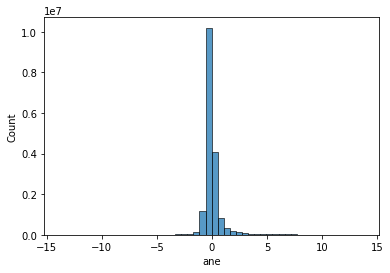

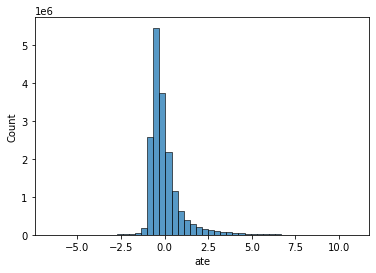

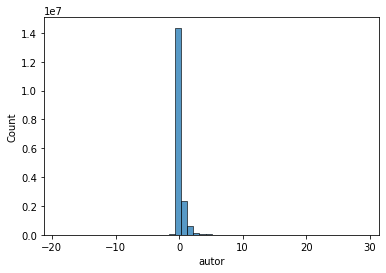

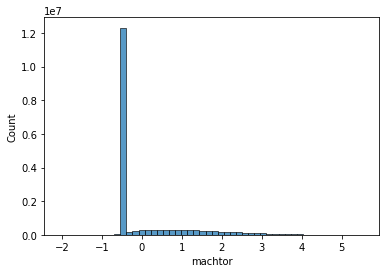

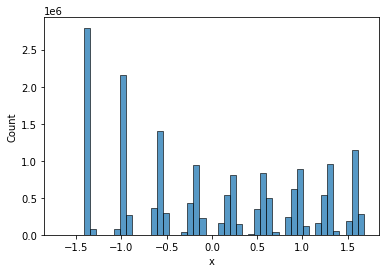

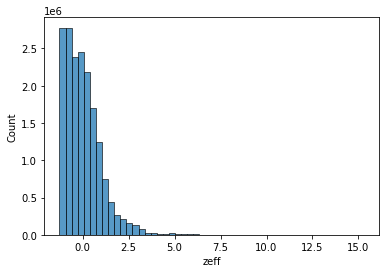

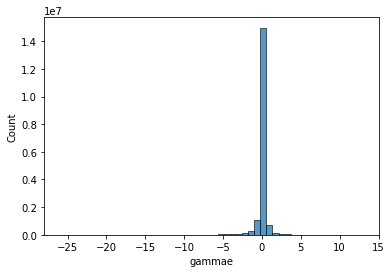

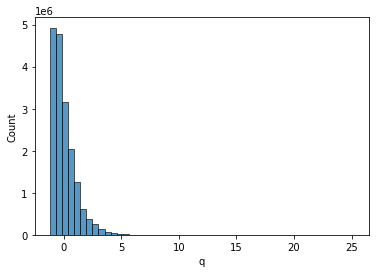

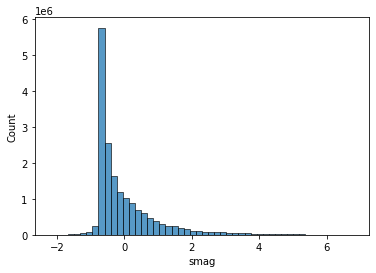

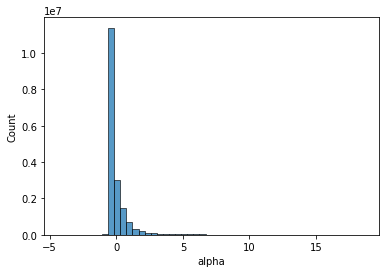

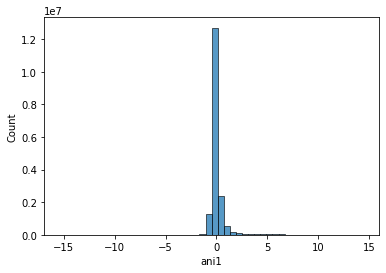

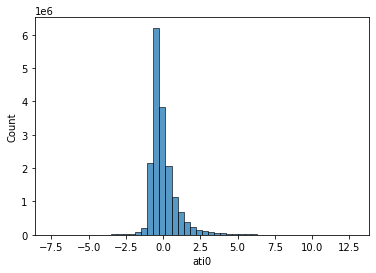

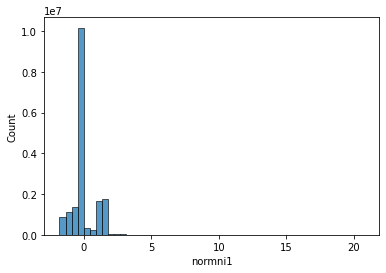

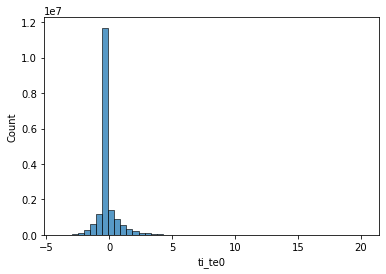

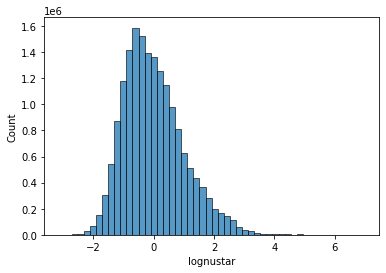

In [6]:
for i in train_keys:
    plt.figure()
    sns.histplot(data = train_data, x = i, bins = 50)

In [7]:
# get upper and lower bounds for each variable and store in a dictionary
bounds_dict = {}
for i in train_keys:
    bounds_dict[i] = [train_data[i].min(), train_data[i].max()]

bounds_dict

{'ane': [-13.841016764527534, 13.777024039385351],
 'ate': [-6.582256824699131, 10.872672978231225],
 'autor': [-18.820996058432463, 29.03888476760202],
 'machtor': [-2.065595333579178, 5.551486487631029],
 'x': [-1.6855056250853842, 1.6791903367379197],
 'zeff': [-1.2710598430094526, 15.293016339332652],
 'gammae': [-26.05024918477381, 13.101109904783291],
 'q': [-1.226442635241779, 25.22869461657117],
 'smag': [-2.2070857958969796, 6.817504212990487],
 'alpha': [-4.268324987997649, 18.57961203838916],
 'ani1': [-15.426763159208013, 14.476368476961794],
 'ati0': [-7.614342528297113, 12.824849572166386],
 'normni1': [-1.8102413817747534, 20.734186225948772],
 'ti_te0': [-3.9622746749361144, 20.24053993289624],
 'lognustar': [-3.129013932222588, 6.969731171060493]}

In [8]:
# Sample a point uniformly from each dimension
def sample_point(bounds_dict, n_points = 1):
    samples = []
    for i in range(n_points):
        point = {}
        for i in train_keys:
            point[i] = np.random.uniform(bounds_dict[i][0], bounds_dict[i][1])
        samples.append(point)

    return samples


In [9]:
sampled_points = sample_point(bounds_dict, 10)
print(sampled_points[0])

{'ane': -5.210451292149408, 'ate': -1.6666409952209307, 'autor': 19.927714466658706, 'machtor': -0.5411904884135428, 'x': 0.5072703039747843, 'zeff': 14.241079807236407, 'gammae': -5.260962728720287, 'q': 5.050682905715308, 'smag': 6.734839904093986, 'alpha': 15.745554055674834, 'ani1': 5.946499961169286, 'ati0': -6.277162872631688, 'normni1': 5.25611603629593, 'ti_te0': 1.0201959879526181, 'lognustar': 1.461209666412819}


In [10]:
# Find point in training data closest to sampled point by L2 distance
def distance(row, sampled_point):
    distance = 0
    for i in train_keys:
        distance += (row[i] - sampled_point[i])**2
    return np.sqrt(distance)

def find_closest_point(sampled_point, train_data):
    distances = train_data.progress_apply(distance, axis = 1, args = (sampled_point,))
    # return closest point
    #return train_data.iloc[np.argmin(distances)]
    #return top 100
    return train_data.iloc[np.argsort(distances)[:100]]
    #return distances.idxmin()


In [12]:
tqdm.pandas()
closest = []
for i in sampled_points:
    closest.append(find_closest_point(i, train_data.sample(frac = 0.01)))

100%|██████████| 176714/176714 [00:10<00:00, 17219.77it/s]


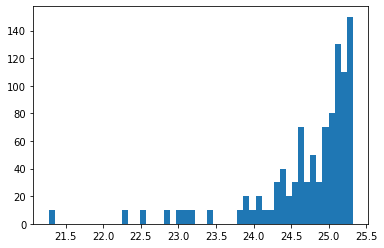

In [13]:
distances = []
for i in range(len(sampled_points)):
    distances.append(distance(closest[0], sampled_points[0]))

x = np.asarray(distances).flatten()
plt.figure()
plt.hist(x, bins = 50);

In [14]:
# find first point closer than a distance of 25
def find_closest_point_threshold(sampled_point, train_data, distance_threshold = 30):
    #for row in train_data.itertuples():
    for row in train_data.iterrows():
        vals = row[1]

        # calculate l2 distance
        distance = 0
        for i in train_keys:
            distance += (vals[i] - sampled_point[i])**2
        distance = np.sqrt(distance)

        # if distance is less than threshold, return point
        if distance < distance_threshold:
            return vals
    

In [16]:
closest_threshold = find_closest_point_threshold(sampled_points[0], train_data.sample(frac = 0.1))

In [18]:
distance(closest_threshold, sampled_points[0])

26.34541929264012

In [21]:
# Sample 1000 points 
samples = sample_point(bounds_dict, n_points = 10)

In [22]:
closest_points = []
for i in tqdm(samples):
    closest_points.append(find_closest_point_threshold(i, train_data.sample(frac = 0.1), distance_threshold = 35))

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


In [23]:
import numba as nb

In [24]:
def sample_point_array(bounds_dict, n_points = 10):
    samples = []
    for i in range(n_points):
        point = []
        for i in train_keys:
            point.append(np.random.uniform(bounds_dict[i][0], bounds_dict[i][1]))
        samples.append(point)

    return np.asarray(samples)

In [39]:
samples_array = sample_point_array(bounds_dict, n_points = 10_000)
#train_data_array = train_data.sample(frac = 0.1).values
train_data_array = train_data.sample(frac = 0.1).values

In [40]:

# create numba version of find_closest_point_threshold
@nb.jit
def find_closest_point_threshold_numba(sample, train_data, distance_threshold = 30):
    for row in train_data:
        # calculate l2 distance
        distance = np.linalg.norm(row - sample)

        # if distance is less than threshold, return point
        if distance < distance_threshold:
            return row

In [41]:
closest_array = np.apply_along_axis(find_closest_point_threshold_numba, 1, samples_array, train_data_array, distance_threshold = 30)

In [42]:
np.linalg.norm(closest_array[0] - samples_array[0])

29.07824316909899

In [43]:
closest_df = pd.DataFrame(closest_array, columns = train_keys)

In [44]:
print(closest_df.isna().sum())

closest_df = closest_df.dropna()

ane          778
ate          778
autor        778
machtor      778
x            778
zeff         778
gammae       778
q            778
smag         778
alpha        778
ani1         778
ati0         778
normni1      778
ti_te0       778
lognustar    778
dtype: int64


In [45]:
train_data_copy = train_data.copy()

train_data_copy["hue"] = "original"
closest_df["hue"] = "closest"

concat_df = pd.concat([train_data_copy.sample(len(closest_df.index)), closest_df]).reset_index(drop = True)

In [46]:
concat_df

,ane,ate,autor,machtor,x,zeff,gammae,q,smag,alpha,ani1,ati0,normni1,ti_te0,lognustar,hue
0,-0.091259,0.969682,-0.291835,-0.530952,1.200953,0.232934,0.042775,1.648665,0.662594,-0.303045,-0.052202,0.163634,-0.254491,-0.108225,1.458881,original
1,-0.595114,-0.733873,-0.291835,-0.530952,-1.367708,-0.503023,0.042775,-0.847463,-0.692942,-0.462165,-0.443898,-0.700140,-0.226227,-0.156001,-0.052054,original
2,0.850855,1.065906,1.030580,0.269880,1.296334,-0.128186,0.241523,0.530048,1.279155,1.489571,1.485588,-0.565373,-0.820834,0.153586,-0.368190,original
3,-0.367069,-0.744665,-0.102375,1.153770,-1.365876,-1.113822,0.537673,-0.923788,-0.663865,-0.327923,-0.343984,-0.738487,-1.001111,-0.523094,1.036198,original
4,-0.154614,-0.250072,-0.291835,-0.530952,-1.009704,2.742640,0.042775,-0.280737,-0.645797,-0.517647,-0.268579,-0.572125,1.198787,-0.108225,0.592879,original
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18439,6.857983,2.008415,0.708489,-0.040592,1.590951,1.285467,-0.191404,2.317186,1.357950,3.397277,7.273252,3.107147,-0.705424,4.372419,1.794545,closest
18440,1.103623,-0.852688,-0.291835,-0.530952,1.596151,-0.075832,0.042775,3.268411,3.382721,0.975708,1.211874,1.668640,-0.109316,3.906713,1.678088,closest
18441,1.461595,2.947934,-0.291835,-0.530952,1.616729,-0.843207,0.042775,1.250593,0.817798,-0.207480,0.259319,5.006976,-0.213163,-0.108225,1.322243,closest
18442,-0.135777,4.973408,-0.291835,-0.530952,1.532967,0.983099,0.042775,2.344148,-0.019404,-0.335264,-0.099298,-1.841720,1.338090,-0.108225,1.557460,closest


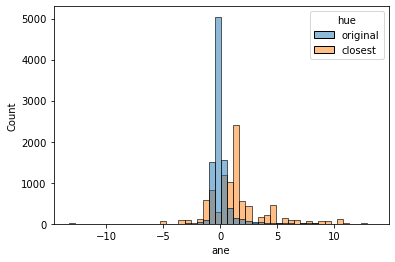

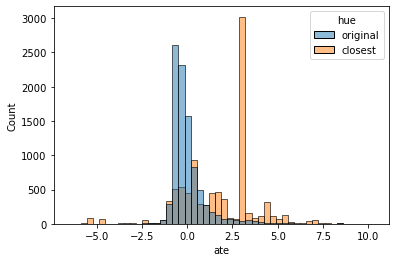

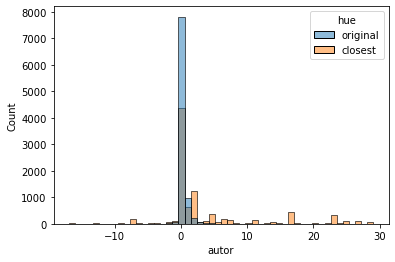

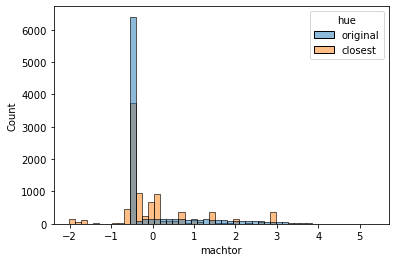

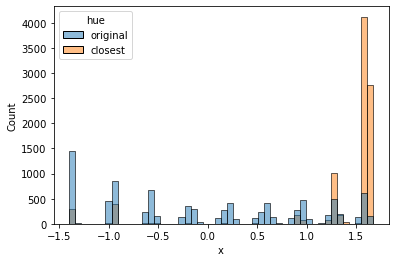

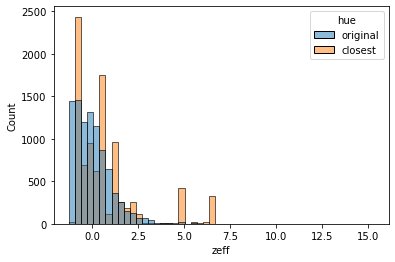

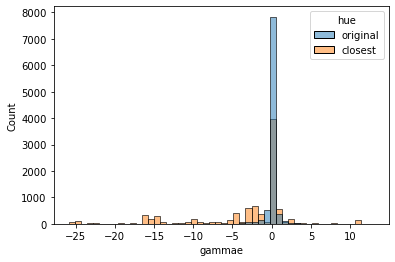

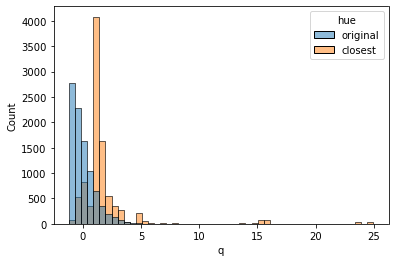

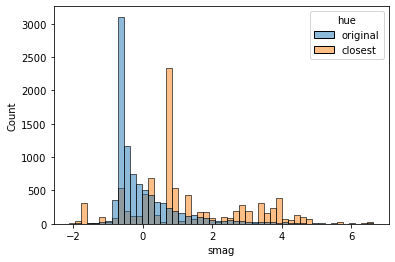

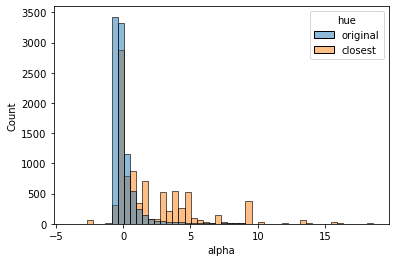

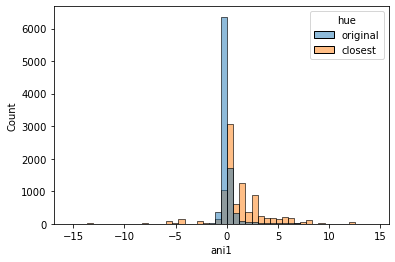

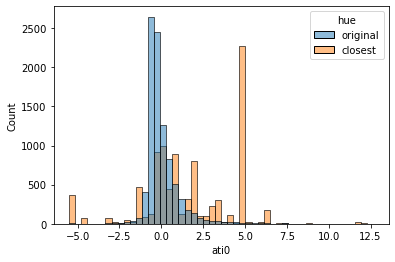

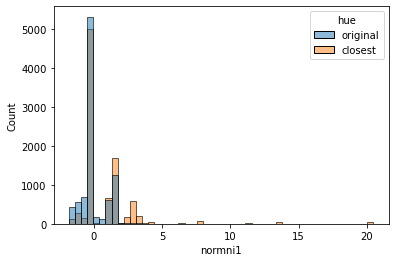

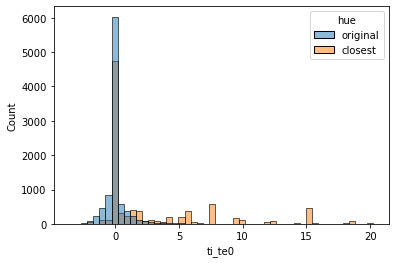

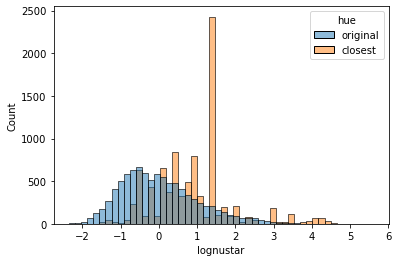

In [47]:
for i in train_keys:
    plt.figure()
    sns.histplot(data = concat_df, x = i, bins = 50, hue = "hue")

In [50]:
samples_array2 = sample_point_array(bounds_dict, n_points = 100)
train_data_array2 = train_data.values

In [51]:
closest_array = np.apply_along_axis(find_closest_point_threshold_numba, 1, samples_array2, train_data_array2, distance_threshold = 30)

### Using Autoencoder to reduce dimensionality

In [11]:
from scripts.AutoEncoder import AutoEncoder, AutoEncoderDataset, Encoder, Decoder
from scripts.AutoEncoder import EncoderBig, DecoderBig, EncoderHuge, DecoderHuge

In [89]:
path = "/unix/atlastracking/jbarr/UKAEAGroupProject/experiment_name=0-epoch=127-val_loss=0.03.ckpt"
model = AutoEncoder.load_from_checkpoint(path, encoder = EncoderHuge, decoder = DecoderHuge,
                                         n_input = 15, batch_size = 2048, epochs = 150, learning_rate = 0.001)
encoder = model.encoder

In [179]:
train_data = pd.read_pickle("/unix/atlastracking/jbarr/train_data_clipped.pkl")
validation_data = pd.read_pickle("/unix/atlastracking/jbarr/valid_data_clipped.pkl")

# Keep only the data that gives an output
train_data = train_data[train_data["target"] == 1]
validation_data = validation_data[validation_data["target"] == 1]

In [180]:
keys = train_keys + ['efiitg_gb']
train_data = train_data[keys]
validation_data = validation_data[keys].sample(100_000)

train_data = train_data.dropna()
validation_data = validation_data.dropna()

In [181]:
scaler = StandardScaler()
scaler.fit(train_data);

train_data = pd.DataFrame(scaler.transform(train_data), columns = keys, index = train_data.index)

target = train_data['efiitg_gb']
train_data = train_data.drop(columns = ['efiitg_gb'])

In [182]:
train_data_array = train_data.values
index_array = train_data.index.values
train_tensor = torch.tensor(train_data_array, dtype = torch.float32)

encoded_points = encoder(train_tensor)
encoded_array = encoded_points.detach().numpy()

In [183]:
H, edges = np.histogramdd(encoded_array, bins = (50, 50, 50))


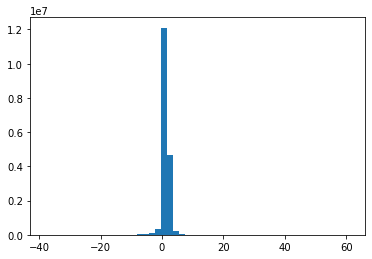

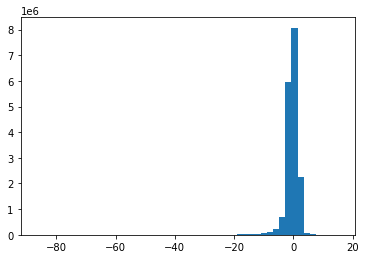

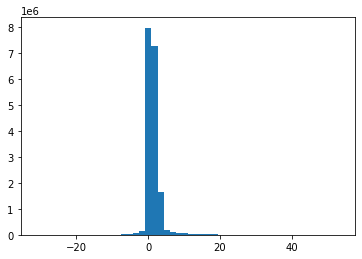

In [184]:
# plot 1D histogram slices
for i in range(3):
    plt.figure()
    plt.hist(encoded_array[:, i], bins = 50)

In [185]:
#!!! np digitize has an extra bin at the end compared to histogramdd!!

# get which bin each point is in
bin_x = np.fmin(np.digitize(encoded_array[:, 0], edges[0]), len(edges[0]) - 1)
bin_y = np.fmin(np.digitize(encoded_array[:, 1], edges[1]), len(edges[1]) - 1)
bin_z = np.fmin(np.digitize(encoded_array[:, 2], edges[2]), len(edges[2]) - 1)

In [186]:
bin_lists = [[] for _ in range (50**3)]

for i in range(len(encoded_array)):
    # digitize returns 1 indexed arrays instead of 0 indexed for some reason!!
    idx = np.ravel_multi_index((bin_x[i] - 1, bin_y[i] - 1, bin_z[i] - 1), (50, 50, 50))
    bin_lists[idx].append(i) #appending the index of the point in the list of points in the bin

In [187]:

def get_points_in_bin(bin_list, n_points = 10):
    index = []
    counts = []

    for i in range(n_points):
        sampled = False
        count = 0
        while not sampled:
            count += 1

            # randomly select integer from 0 to len(bin_lists) and sample a point from that bin
            bin_number = np.random.randint(0, len(bin_lists))

            bin_length = len(bin_lists[bin_number])

            # sample from bin only if bin is not empty
            if bin_length > 0:
                sampled_index = bin_lists[bin_number][np.random.randint(0, bin_length)]

                # check if point is already sampled
                if sampled not in index:
                    sampled = True

        index.append(sampled_index)
        counts.append(count)

    return index, counts


In [188]:
indices, counts = get_points_in_bin(bin_lists, n_points = 10_000)

32.9979


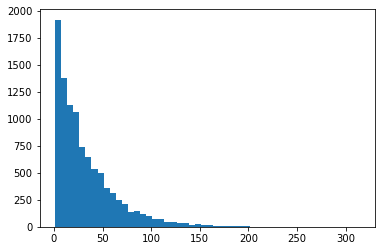

In [189]:
plt.figure()
plt.hist(counts, bins = 50);
print(np.mean(counts))

In [190]:
sampled_values = train_data_array[indices]
sampled_df = pd.DataFrame(sampled_values, columns = train_keys, index = index_array[indices])
sampled_df

,ane,ate,autor,machtor,x,zeff,gammae,q,smag,alpha,ani1,ati0,normni1,ti_te0,lognustar
22053823,10.363671,4.548238,0.504898,-0.423483,1.586443,-0.579279,-0.503254,1.005714,0.188066,3.038949,9.147718,2.412368,-1.363214,-1.062304,0.530965
18164940,-1.870584,0.036724,-0.291835,-0.530952,1.545710,-0.971207,0.042775,4.277935,-1.809371,-0.296954,0.225674,-0.902771,-0.267232,-0.108225,2.484799
2116833,-0.699329,-0.229863,-0.291835,-0.530952,0.597547,-0.015176,0.042775,-0.098085,-0.344454,-3.981170,-0.217657,2.767611,-0.111843,2.208646,0.993321
19430367,7.274465,-3.813488,-0.291835,-0.530952,1.644566,-0.295595,0.042775,5.856724,-1.165366,-0.712895,1.332605,-4.372198,-0.234193,-0.108225,4.374199
21187002,5.433699,-4.926201,-0.291835,-0.530952,1.646007,-0.311139,0.042775,6.334601,2.970641,-0.476970,2.411978,-1.206724,-0.233596,-0.108225,5.398550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26185832,5.547447,-5.276798,25.005561,-1.612535,1.611296,2.060768,2.810790,2.868450,6.563766,2.950041,5.913037,0.272902,1.252771,15.209425,3.528866
26613055,-1.184997,0.281671,7.588417,-0.750001,1.585946,0.411430,-1.545862,1.861797,5.400331,7.531843,0.884536,2.059711,1.383351,0.484214,0.734833
13776627,7.237692,-6.099473,-0.291835,-0.530952,1.640017,-0.934434,0.042775,8.939268,3.444413,-0.765814,-2.222859,-2.456689,-0.209659,-0.108225,6.850231
23049037,11.166644,-0.674037,0.448495,-0.053574,1.614479,0.495067,-0.417438,0.907219,4.171131,1.305560,1.844842,3.696261,-0.683064,0.944847,2.649204


In [191]:
# add back efiitg_gb
sampled_df["efiitg_gb"] = target.loc[index_array[indices]]

# unnormalize
sampled_df_unscaled = pd.DataFrame(scaler.inverse_transform(sampled_df),
    columns = scaler.feature_names_in_,
    index = sampled_df.index
    )

In [192]:
sampled_df_unscaled

,ane,ate,autor,machtor,x,zeff,gammae,q,smag,alpha,ani1,ati0,normni1,ti_te0,lognustar,efiitg_gb
22053823,76.003840,45.645990,1.288696,0.020460,0.928450,1.445477,-0.414564,3.281224,1.186726,1.674246,63.652180,23.594930,0.004655,0.813141,-0.187191,0.0000
18164940,-9.924100,6.902524,0.000000,0.000000,0.917172,1.193691,0.000000,7.146319,-1.467759,0.127152,4.417931,-0.717716,0.016057,1.000000,0.775721,0.0000
2116833,-1.697728,4.613157,0.000000,0.000000,0.654632,1.807873,0.000000,1.977434,0.479037,-1.581480,1.474611,26.200220,0.017674,1.453765,0.040673,136.9459
19430367,54.306640,-26.161890,0.000000,0.000000,0.944544,1.627724,0.000000,9.011159,-0.611912,-0.065750,11.766940,-26.161890,0.016401,1.000000,1.706878,0.0000
21187002,41.377920,-35.717520,0.000000,0.000000,0.944944,1.617738,0.000000,9.575620,4.884619,0.043666,18.933000,-2.946859,0.016407,1.000000,2.211711,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26185832,42.176840,-38.728340,40.917900,-0.205908,0.935332,3.141520,2.101572,5.481457,9.659688,1.633013,42.176840,7.904461,0.031870,4.000001,1.290271,0.0000
26613055,-5.108843,9.006051,12.746110,-0.041702,0.928313,2.081937,-1.206148,4.292415,8.113545,3.757919,8.792170,21.008610,0.033228,1.116031,-0.086718,0.0000
13776627,54.048360,-45.793210,0.000000,0.000000,0.943285,1.217315,0.000000,12.652210,5.514236,-0.090292,-11.838100,-12.113880,0.016656,1.000000,2.927146,0.0000
23049037,81.643570,0.798729,1.197465,0.090882,0.936214,2.135668,-0.349409,3.164883,6.480005,0.870351,15.167730,33.010780,0.011731,1.206247,0.856745,0.0000


In [193]:
sanity_check = train_data.loc[index_array[indices]]

In [194]:
index_array[indices].shape

(10000,)

In [202]:
sanity_check.equals(sampled_df_unscaled.drop(columns = ['efiitg_gb']))

False

In [204]:
sanity_check

,ane,ate,autor,machtor,x,zeff,gammae,q,smag,alpha,ani1,ati0,normni1,ti_te0,lognustar
22053823,10.363671,4.548238,0.504898,-0.423483,1.586443,-0.579279,-0.503254,1.005714,0.188066,3.038949,9.147718,2.412368,-1.363214,-1.062304,0.530965
18164940,-1.870584,0.036724,-0.291835,-0.530952,1.545710,-0.971207,0.042775,4.277935,-1.809371,-0.296954,0.225674,-0.902771,-0.267232,-0.108225,2.484799
2116833,-0.699329,-0.229863,-0.291835,-0.530952,0.597547,-0.015176,0.042775,-0.098085,-0.344454,-3.981170,-0.217657,2.767611,-0.111843,2.208646,0.993321
19430367,7.274465,-3.813488,-0.291835,-0.530952,1.644566,-0.295595,0.042775,5.856724,-1.165366,-0.712895,1.332605,-4.372198,-0.234193,-0.108225,4.374199
21187002,5.433699,-4.926201,-0.291835,-0.530952,1.646007,-0.311139,0.042775,6.334601,2.970641,-0.476970,2.411978,-1.206724,-0.233596,-0.108225,5.398550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26185832,5.547447,-5.276798,25.005561,-1.612535,1.611296,2.060768,2.810790,2.868450,6.563766,2.950041,5.913037,0.272902,1.252771,15.209425,3.528866
26613055,-1.184997,0.281671,7.588417,-0.750001,1.585946,0.411430,-1.545862,1.861797,5.400331,7.531843,0.884536,2.059711,1.383351,0.484214,0.734833
13776627,7.237692,-6.099473,-0.291835,-0.530952,1.640017,-0.934434,0.042775,8.939268,3.444413,-0.765814,-2.222859,-2.456689,-0.209659,-0.108225,6.850231
23049037,11.166644,-0.674037,0.448495,-0.053574,1.614479,0.495067,-0.417438,0.907219,4.171131,1.305560,1.844842,3.696261,-0.683064,0.944847,2.649204


In [203]:
sampled_df_unscaled

,ane,ate,autor,machtor,x,zeff,gammae,q,smag,alpha,ani1,ati0,normni1,ti_te0,lognustar,efiitg_gb
22053823,76.003840,45.645990,1.288696,0.020460,0.928450,1.445477,-0.414564,3.281224,1.186726,1.674246,63.652180,23.594930,0.004655,0.813141,-0.187191,0.0000
18164940,-9.924100,6.902524,0.000000,0.000000,0.917172,1.193691,0.000000,7.146319,-1.467759,0.127152,4.417931,-0.717716,0.016057,1.000000,0.775721,0.0000
2116833,-1.697728,4.613157,0.000000,0.000000,0.654632,1.807873,0.000000,1.977434,0.479037,-1.581480,1.474611,26.200220,0.017674,1.453765,0.040673,136.9459
19430367,54.306640,-26.161890,0.000000,0.000000,0.944544,1.627724,0.000000,9.011159,-0.611912,-0.065750,11.766940,-26.161890,0.016401,1.000000,1.706878,0.0000
21187002,41.377920,-35.717520,0.000000,0.000000,0.944944,1.617738,0.000000,9.575620,4.884619,0.043666,18.933000,-2.946859,0.016407,1.000000,2.211711,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26185832,42.176840,-38.728340,40.917900,-0.205908,0.935332,3.141520,2.101572,5.481457,9.659688,1.633013,42.176840,7.904461,0.031870,4.000001,1.290271,0.0000
26613055,-5.108843,9.006051,12.746110,-0.041702,0.928313,2.081937,-1.206148,4.292415,8.113545,3.757919,8.792170,21.008610,0.033228,1.116031,-0.086718,0.0000
13776627,54.048360,-45.793210,0.000000,0.000000,0.943285,1.217315,0.000000,12.652210,5.514236,-0.090292,-11.838100,-12.113880,0.016656,1.000000,2.927146,0.0000
23049037,81.643570,0.798729,1.197465,0.090882,0.936214,2.135668,-0.349409,3.164883,6.480005,0.870351,15.167730,33.010780,0.011731,1.206247,0.856745,0.0000


In [205]:
# pickle sampled data
with open("sampled_data.pkl", "wb") as f:
    pickle.dump(sampled_df_unscaled, f)

In [57]:
train_data_copy = train_data.copy()

train_data_copy["hue"] = "original"
sampled_df["hue"] = "closest"

concat_df = pd.concat([train_data_copy.sample(len(sampled_df.index)), sampled_df]).reset_index(drop = True)

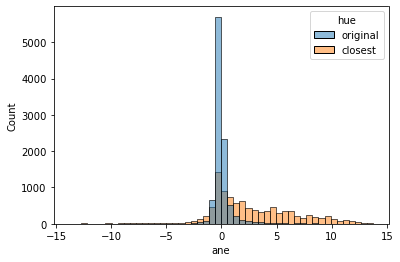

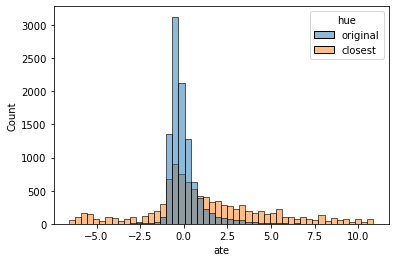

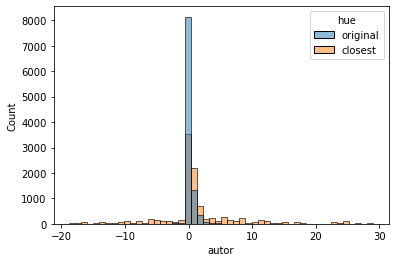

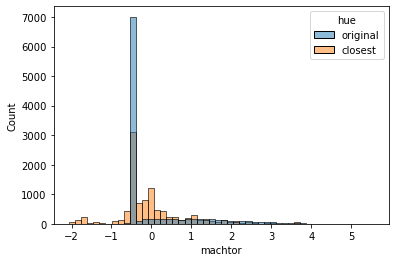

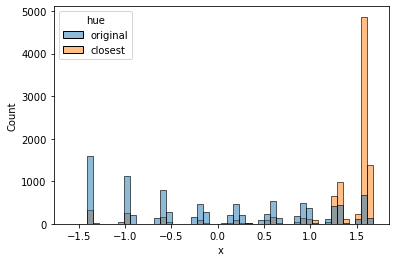

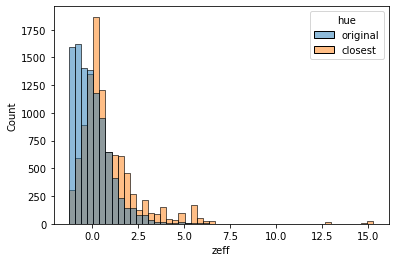

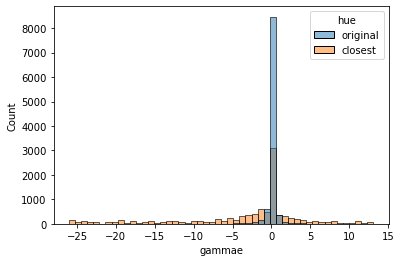

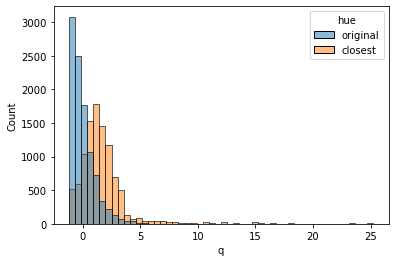

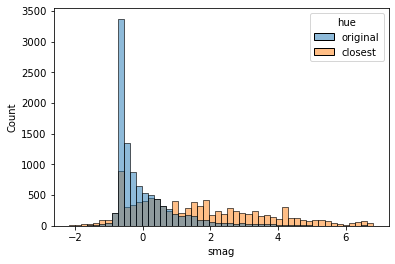

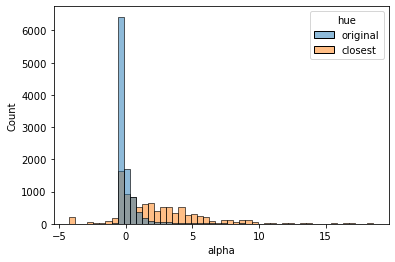

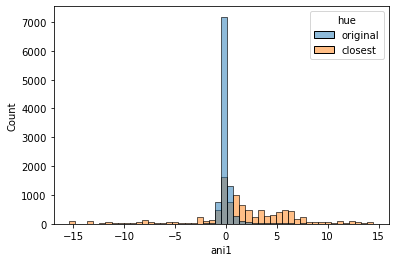

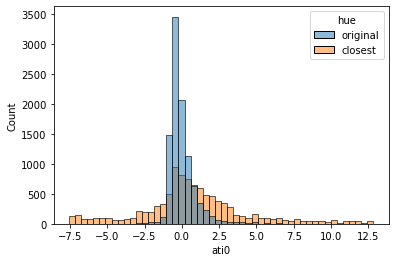

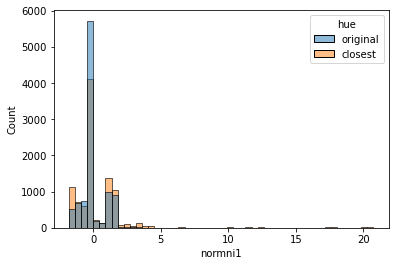

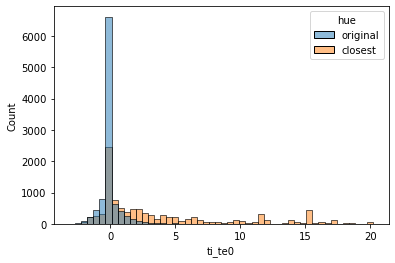

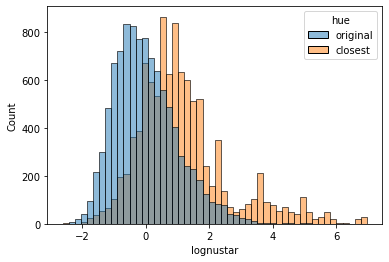

In [58]:
for i in train_keys:
    plt.figure()
    sns.histplot(data = concat_df, x = i, bins = 50, hue = "hue")

## Try method of getting coordinates and sampling coordinates

In [67]:
# for each column, get bin edges
bin_edges = []
for i in train_keys:
    bin_edges.append(np.linspace(train_data[i].min(), train_data[i].max(), 50)) 

bin_edges = np.array(bin_edges)

In [80]:
bin_edges[0]

array([-13.84101676, -13.27738328, -12.71374979, -12.15011631,
       -11.58648282, -11.02284934, -10.45921585,  -9.89558236,
        -9.33194888,  -8.76831539,  -8.20468191,  -7.64104842,
        -7.07741493,  -6.51378145,  -5.95014796,  -5.38651448,
        -4.82288099,  -4.25924751,  -3.69561402,  -3.13198053,
        -2.56834705,  -2.00471356,  -1.44108008,  -0.87744659,
        -0.31381311,   0.24982038,   0.81345387,   1.37708735,
         1.94072084,   2.50435432,   3.06798781,   3.6316213 ,
         4.19525478,   4.75888827,   5.32252175,   5.88615524,
         6.44978872,   7.01342221,   7.5770557 ,   8.14068918,
         8.70432267,   9.26795615,   9.83158964,  10.39522312,
        10.95885661,  11.5224901 ,  12.08612358,  12.64975707,
        13.21339055,  13.77702404])

In [59]:
train_samples = train_data.sample(100).values

In [70]:
edges = np.digitize(train_samples[0], bin_edges)

ValueError: object too deep for desired array

In [91]:
train_data_sample = train_data.copy()

In [103]:
for i in range(len(train_keys)):
    train_data_sample[f"{train_keys[i]}_bin"] = np.digitize(train_data_sample[train_keys[i]], bin_edges[i])

train_data_coords = train_data_sample.drop(columns = train_keys)

In [104]:
train_data_coords

,ane_bin,ate_bin,autor_bin,machtor_bin,x_bin,zeff_bin,gammae_bin,q_bin,smag_bin,alpha_bin,ani1_bin,ati0_bin,normni1_bin,ti_te0_bin,lognustar_bin
31980701,24,18,20,29,11,2,36,1,9,9,26,18,4,10,11
30920680,24,17,20,30,11,1,33,2,9,10,25,18,2,8,12
5951936,27,6,19,10,48,3,33,6,13,9,26,16,4,8,28
8815332,25,18,19,10,17,2,33,1,9,8,25,17,3,8,9
6161299,24,18,19,10,17,3,33,1,10,8,25,18,4,8,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13315092,24,17,19,10,5,2,33,1,9,8,25,17,4,8,20
26858567,25,19,21,22,34,3,33,2,13,10,26,18,4,8,12
23327850,25,19,20,26,33,5,27,2,13,11,25,18,6,9,10
23200604,25,18,20,37,16,7,36,1,8,10,28,19,8,11,11


In [111]:
sample_coordinates = np.random.randint(0, 50, size = 15)

In [121]:

flag = False
count = 0
while not flag:
    print(count)
    sample_coordinates = np.random.randint(0, 50, size = 15)
    # check if any row in train_data_coords has the same coordinates as sample_coordinates
    true_vals = train_data[train_data_coords.isin(sample_coordinates).all(axis = 1) == True]

    flag = bool(len(true_vals))
    count += 1

    if count > 500:
        break

print(f"Found a value after {count} tries")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
Found a value after 243 tries


In [141]:
import scripts.Models as models
import scripts.pipeline_tools as tools

In [111]:
train_path = "/unix/atlastracking/jbarr/UKAEAGroupProject/src/notebooks/sampled_data.pkl"
valid_path = "/unix/atlastracking/jbarr/valid_data_clipped.pkl"

train, val = tools.prepare_data(
    train_path,
    valid_path,
    target_column="efiitg_gb",
    target_var="itg",
    valid_size=1_000_000,
)

In [112]:
scaler = StandardScaler()
scaler.fit_transform(train_data.drop(["itg"], axis=1))

array([[-0.82731773, -0.47579851,  0.88442714, ..., -0.61575254,
        -0.9499439 , -0.31453427],
       [ 1.48127319, -0.2204763 , -0.00479462, ...,  0.19970545,
         0.24974183,  0.74133687],
       [ 0.88724178,  0.28726886,  0.66212241, ...,  1.55044382,
         0.80222337, -0.31453427],
       ...,
       [-1.10201421, -0.95192003, -0.2465237 , ..., -0.72713151,
         1.58221654, -0.31453427],
       [-0.40598413, -0.35467319, -0.08712077, ...,  2.43739344,
        -0.44270453, -0.31453427],
       [ 1.04945917,  1.09968337,  0.31794517, ...,  0.20237899,
        -0.62498154,  4.26141652]])

In [139]:
train_dataset = models.ITGDatasetDF(train_data, target_column="efiitg_gb", target_var="itg")
valid_dataset = models.ITGDatasetDF(val_data, target_column="efiitg_gb", target_var="itg")

train_dataset.scale(scaler)
valid_dataset.scale(scaler)

train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True, num_workers=4)


# Switching validation dataset to numpy arrays to see if it is quicker
x_array = valid_dataset.data[train_keys].values
y_array = valid_dataset.data["itg"].values
z_array = valid_dataset.data["efiitg_gb"].values
dataset_numpy = models.ITGDataset(x_array, y_array, z_array)

valid_loader = DataLoader(
    dataset_numpy, batch_size=int(0.1 * len(y_array)), shuffle=True
)

In [207]:
classifier = ITG_Classifier()

train_loss, val_loss, val_acc = train_model(classifier, 
    train_loader, 
    valid_loader, 
    epochs=50,
    learning_rate=0.001,
    weight_decay=1e-4,
    )

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0
Average loss: 0.5964


  2%|▏         | 1/50 [00:22<18:06, 22.17s/it]

Test accuracy: 0.733050, loss: 35.341300
Epoch 1
Average loss: 0.4839


  4%|▍         | 2/50 [01:03<26:39, 33.33s/it]

Test accuracy: 0.733050, loss: 31.975742
Epoch 2
Average loss: 0.4368


  6%|▌         | 3/50 [01:18<19:37, 25.04s/it]

Test accuracy: 0.733050, loss: 33.419690
Epoch 3
Average loss: 0.4109


  8%|▊         | 4/50 [01:33<16:14, 21.18s/it]

Test accuracy: 0.733050, loss: 31.458599
Epoch 4
Average loss: 0.3944


In [163]:
def train_model(
    model, train_loader, val_loader, epochs, learning_rate, weight_decay=None
):

    # Initialise the optimiser
    if weight_decay:
        opt = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    else:
        opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

    losses = []
    validation_losses = []

    if model.type == "classifier":
        val_acc = []

        for epoch in tqdm(range(epochs)):
            print(f"Epoch {epoch}")
            loss = model.train_step(train_loader, opt)
            losses.append(loss)

            val_loss, acc = model.validation_step(val_loader)
            validation_losses.append(validation_losses)
            val_acc.append(acc)
        return losses, validation_losses, val_acc

    elif model.type == "regressor":

        for epoch in tqdm(range(epochs)):
            print(f"Epoch {epoch}")
            loss = model.train_step(train_loader, opt)
            losses.append(loss)

            val_loss = model.validation_step(val_loader)
            validation_losses.append(validation_losses)

        return losses, validation_losses

    else:
        raise ValueError("Model type not recognised")

In [206]:
class ITG_Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.type = "classifier"
        self.model = self.model = nn.Sequential(
            nn.Linear(15, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        y_hat = self.model(x)
        return y_hat

    def train_step(self, dataloader, optimizer):
        # Initalise loss function
        BCE = nn.BCELoss(reduction="sum")

        size = len(dataloader.dataset)
        num_batches = len(dataloader)

        losses = []
        for batch, (X, y, z, idx) in enumerate(dataloader):

            y_hat = self.forward(X.float())
            loss = BCE(y_hat, y.unsqueeze(-1).float())

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())

        print(f"Average loss: {np.sum(losses) / size:.4f}")
        return np.sum(losses) / size

    def validation_step(self, dataloader):
        size = len(dataloader.dataset)
        # Initalise loss function
        BCE = nn.BCELoss(reduction="sum")

        test_loss = []
        correct = 0

        with torch.no_grad():
            for X, y, z in dataloader:
                y_hat = self.forward(X.float())
                test_loss.append(BCE(y.unsqueeze(-1).float(), y_hat).item())

                # calculate test accuracy
                pred_class = torch.round(y_hat.squeeze())
                correct += torch.sum(pred_class == y.float()).item()

        correct /= size
        average_loss = np.sum(test_loss) / size
        print(f"Test accuracy: {correct:>7f}, loss: {average_loss:>7f}")
        return average_loss, correct


class ITG_Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.type = "regressor"
        self.model = nn.Sequential(
            nn.Linear(15, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        y_hat = self.model(x.float())
        return y_hat

    def enable_dropout(self):
        """Function to enable the dropout layers during test-time"""
        for m in self.model.modules():
            if m.__class__.__name__.startswith("Dropout"):
                m.train()

    def reset_weights(self):
        self.model.apply(weight_reset)

    def shrink_perturb(self, lam, loc, scale):
        noise_dist = torch.distributions.Normal(
            torch.Tensor([loc]), torch.Tensor([scale])
        )
        noise = noise_dist.sample()

        with torch.no_grad():
            for param in self.model.parameters():
                param_update = (param * lam) + noise
                param.copy_(param_update)

    def loss_function(self, y, y_hat):
        MSE_loss = nn.MSELoss(reduction="sum")
        return MSE_loss(y_hat, y.float())

    def train_step(self, dataloader, optimizer):

        size = len(dataloader.dataset)
        num_batches = len(dataloader)

        losses = []
        for batch, (X, y, z, idx) in enumerate(dataloader):
            batch_size = len(X)
            z_hat = self.forward(X.float())
            loss = self.loss_function(z.unsqueeze(-1).float(), z_hat)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss = loss.item()
            losses.append(loss)

        return np.sum(losses) / size

    def validation_step(self, dataloader):
        size = len(dataloader.dataset)

        test_loss = []
        with torch.no_grad():
            # for X, y, z, idx in tqdm(dataloader):
            for X, y, z in tqdm(dataloader):
                z_hat = self.forward(X.float())
                test_loss.append(
                    self.loss_function(z.unsqueeze(-1).float(), z_hat).item()
                )

        return np.sum(test_loss) / size

    def predict(self, dataloader, order_outputs=None):
        pred = []
        index_ordering = []
        for (x, y, z, idx) in dataloader:
            y_hat = self.forward(x.float())
            pred.append(y_hat.squeeze().detach().numpy())
            index_ordering.append(idx.detach().numpy())

        idx_array = np.asarray(index_ordering, dtype=object).flatten()
        pred = np.asarray(pred).flatten()

        if order_outputs is not None:
            reorder = np.array(
                [np.where(idx_array == i) for i in order_outputs]
            ).flatten()
            pred = pred[reorder]
            real_idx = idx_array[reorder]
            # Make sure the reording has worked
            assert real_idx.tolist() == order_outputs.tolist(), print("Ordering error")

        return pred, idx_array